In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/c5/img_100469.jpg  
  inflating: dataset/train/c5/img_100556.jpg  
  inflating: dataset/train/c5/img_100636.jpg  
  inflating: dataset/train/c5/img_100690.jpg  
  inflating: dataset/train/c5/img_100797.jpg  
  inflating: dataset/train/c5/img_100905.jpg  
  inflating: dataset/train/c5/img_100913.jpg  
  inflating: dataset/train/c5/img_100932.jpg  
  inflating: dataset/train/c5/img_101011.jpg  
  inflating: dataset/train/c5/img_101023.jpg  
  inflating: dataset/train/c5/img_10117.jpg  
  inflating: dataset/train/c5/img_101394.jpg  
  inflating: dataset/train/c5/img_101526.jpg  
  inflating: dataset/train/c5/img_10156.jpg  
  inflating: dataset/train/c5/img_101608.jpg  
  inflating: dataset/train/c5/img_101873.jpg  
  inflating: dataset/train/c5/img_101909.jpg  
  inflating: dataset/train/c5/img_10202.jpg  
  inflating: dataset/train/c5/img_102040.jpg  
  inflating: dataset/train/c5/img_102055.jpg  
  inflating:

# Importing necessary libraries


In [3]:
# PoseGuard: CNN Model for Driver Pose Detection

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
# Constants
IMAGE_SIZE = (224, 224)  # Increased image size
BATCH_SIZE = 32
EPOCHS = 50  # Increased epochs
NUM_CLASSES = 8
MODEL_PATH = '/content/drive/MyDrive/poseguard_model.h5'

In [5]:
# Data directories
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
NUM_CLASSES = 10  # c0 to c9

In [6]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # 20% data for validation
)

# Only preprocessing for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print('Found', len(train_generator.classes), 'training images')
print('Found', len(validation_generator.classes), 'validation images')
print('Found', len(test_generator.classes), 'test images')

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 8000 training images
Found 2000 validation images
Found 5000 test images


In [7]:
def create_model(input_shape=(224, 224, 3), num_classes=8):
    # Using MobileNetV2 as base model
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Fine-tune from this layer onwards
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    # Compile with better optimizer settings
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:
# Callbacks for better training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Load or Create Model
if os.path.exists(MODEL_PATH):
    print('Loading existing model...')
    model = load_model(MODEL_PATH)
else:
    print('Creating and training new model...')
    model = create_model(num_classes=NUM_CLASSES)

    # Train the model using generators
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[reduce_lr, early_stopping]
    )

    # Save the model
    model.save(MODEL_PATH)
    print('Model saved.')

Creating and training new model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 169s 565ms/step - accuracy: 0.4847 - loss: 1.5855 - val_accuracy: 0.5640 - val_loss: 2.5569 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 538ms/step - accuracy: 0.9062 - loss: 0.3327 - val_accuracy: 0.3525 - val_loss: 8.1227 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 647ms/step - accuracy: 0.9258 - loss: 0.2513 - val_accuracy: 0.5440 - val_loss: 2.7527 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 149s 596ms/step - accuracy: 0.9410 - loss: 0.2088 - val_accuracy: 0.5735 - val_loss: 2.9655 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 147s 590ms/step - accuracy: 0.9576 - loss: 0.1553 - val_accuracy: 0.7430 - val_loss: 1.3650 - learning_rate: 2.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 132s 529ms/step - accuracy: 0.9783 - loss: 0.0817 - val_accuracy: 0.9405 - val_loss: 0.2310 - learning_rate: 2.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 131s 523ms/step 

Model saved.


In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9917 - loss: 0.0290
Test Accuracy: 0.99


In [11]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Generate Predictions on test set
test_predictions = model.predict(test_generator)
predicted_test_classes = np.argmax(test_predictions, axis=1)

# The true classes are available from the test_generator
true_test_classes = test_generator.classes

# Report for the test set
print(classification_report(true_test_classes, predicted_test_classes))
print(confusion_matrix(true_test_classes, predicted_test_classes))

157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.9917 - loss: 0.0290
Test Accuracy: 0.99
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500
           4       1.00      1.00      1.00       500
           5       1.00      0.99      0.99       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       0.99      0.97      0.98       500
           9       0.96      0.99      0.97       500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

[[490   0   0   0   0   1   0   0   0   9]
 [  0 499   0   0   0   1   0   0   0   0]
 [  0   1 499

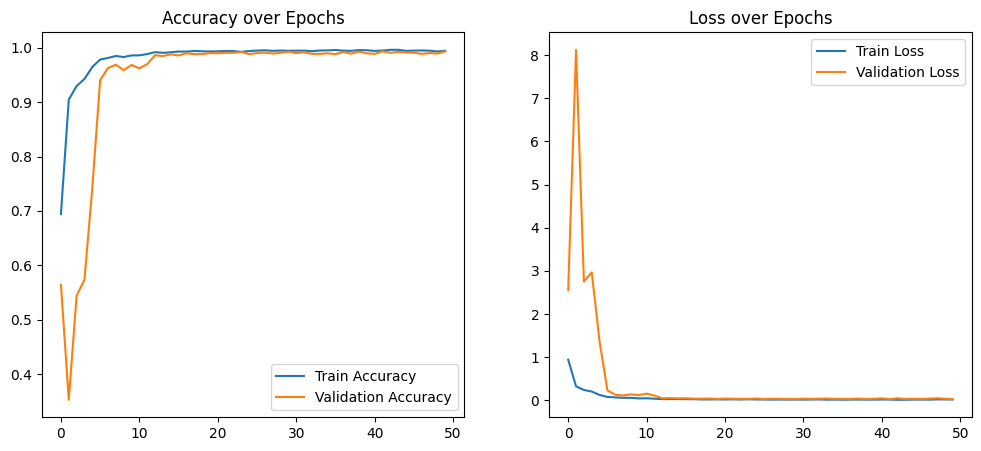

In [12]:
# Visualization of accuracy & loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [13]:
# Alert system
def generate_alert(predicted_class):
    alert_classes = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # Unwanted poses
    if predicted_class in alert_classes:
        print("⚠️ ALERT: Unwanted Pose Detected! ⚠️")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


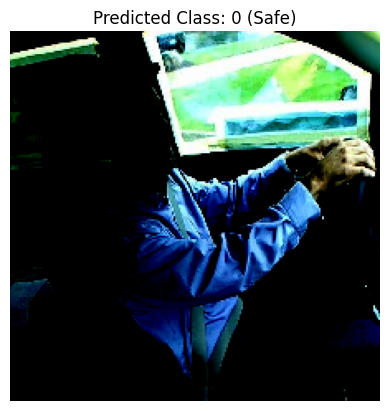

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


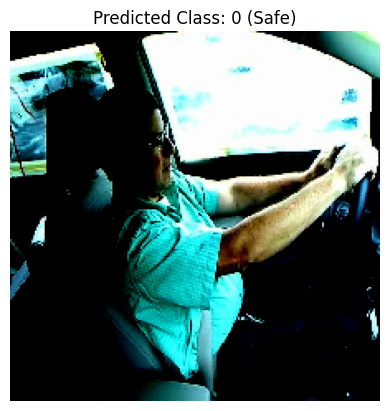

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


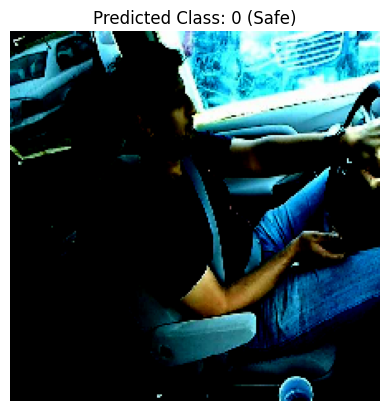

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


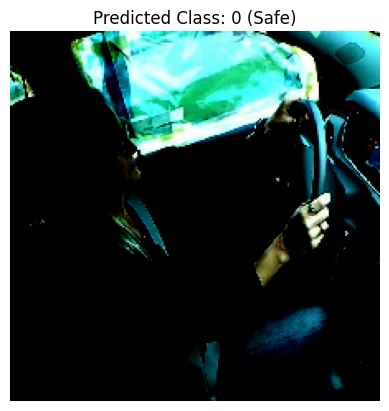

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


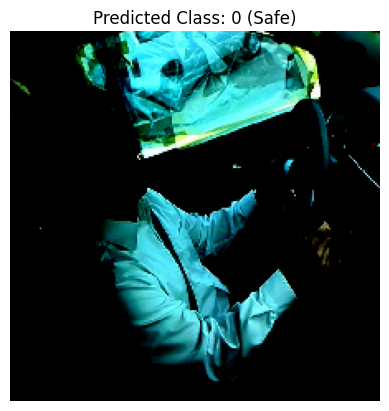

In [25]:
# Testing with sample images from X_test
import random
for i in range(5):
    sample_img = test_generator[9][0][random.randint(0, len(test_generator[0][0])-1)]

    # Reshape and normalize (if not already normalized)
    img_input = sample_img.reshape(1, 224, 224, 3)

    # Predict
    prediction = model.predict(img_input)
    pred_class = np.argmax(prediction)

    # Call alert system (optional)
    generate_alert(pred_class)  # Make sure this function is defined

    # Display image with prediction
    plt.imshow(sample_img)
    plt.title(f"Predicted Class: {pred_class} ({'Safe' if pred_class == 0 else 'Unwanted'})")
    plt.axis('off')
    plt.show()
